In [1]:
from torchvision.datasets import MNIST, cifar
from torch.utils.data import DataLoader
from torchvision import transforms

from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
import torch
from torch import nn
import sys
from tqdm import tqdm

In [2]:
train_dataset = MNIST('.', train=True, download=True,transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False,transform=transforms.ToTensor())

train_loader_MNIST = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_MNIST = DataLoader(test_dataset, batch_size=32, shuffle=False)

t = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = cifar.CIFAR10(root='data',train=True,download=True,transform=t)
test_dataset = cifar.CIFAR10(root='data',train=False,transform=t)

train_loader_CIFAR = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_CIFAR = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35958149.36it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 990803.97it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10604284.09it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3378352.33it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 170498071/170498071 [00:02<00:00, 83009408.45it/s]


Extracting data/cifar-10-python.tar.gz to data


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## LeNet


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [5]:
def train(network,train_loader, test_loader, epochs,loss_fn,optim, plot=True, verbose=True):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X,y = X.to(device), y.to(device)
                pred = model(X)
                loss_batch = loss_fn(pred, y)
                losses.append(loss_batch.item())
                optim.zero_grad()
                loss_batch.backward()
                optim.step()
                accuracies.append((pred.argmax(dim=1) == y).float().mean().item())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            with torch.no_grad():
                losses = []
                accuracies = []
                for X, y in test_loader:
                    X,y = X.to(device), y.to(device)
                    pred = model(X)
                    loss_batch = loss_fn(pred, y)
                    losses.append(loss_batch.cpu())
                    accuracies.append((pred.argmax(dim=1) == y).float().mean().item())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 9... (Train/Test) Loss: 0.313/0.272	Accuracy: 0.907/0.920

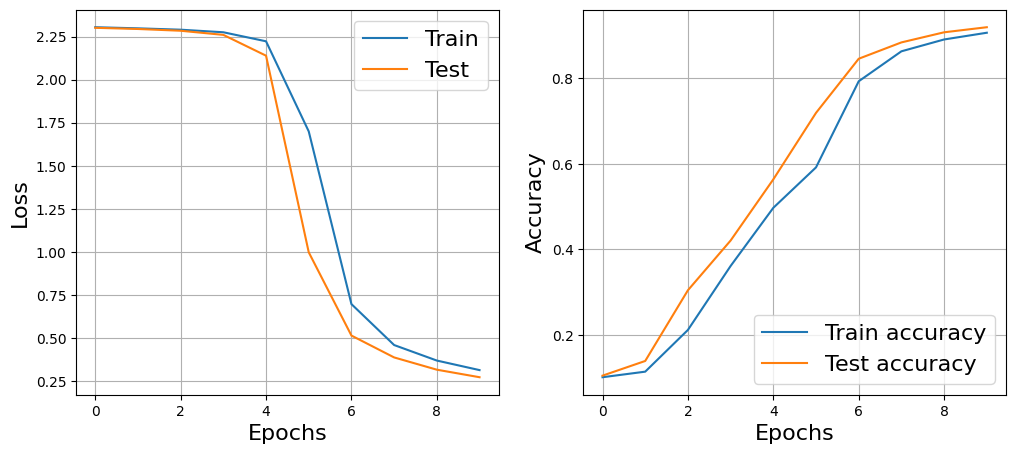

100%|██████████| 10/10 [02:01<00:00, 12.20s/it]


In [6]:
model=LeNet()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.SGD(model.parameters(), lr=lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader_MNIST,test_loader_MNIST, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 9... (Train/Test) Loss: 0.014/0.041	Accuracy: 0.995/0.988

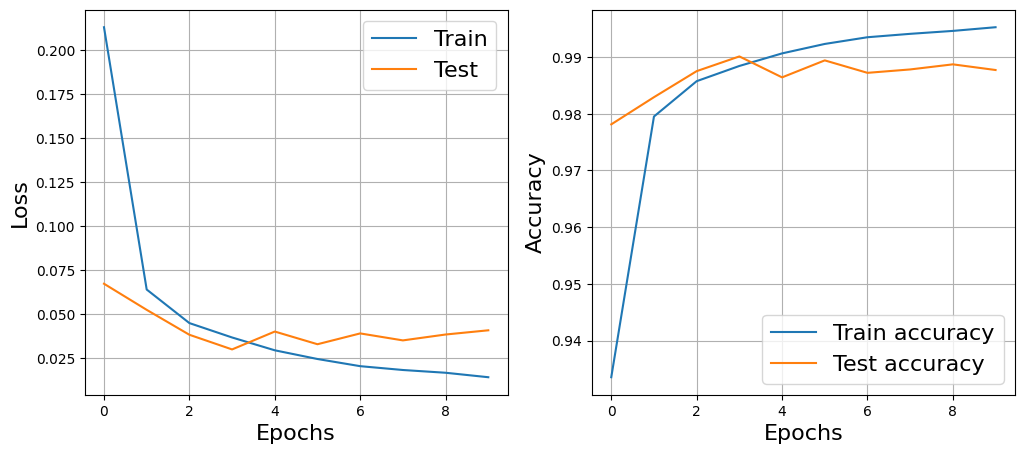

100%|██████████| 10/10 [02:07<00:00, 12.78s/it]


In [7]:
model=LeNet()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=lr)

tr_lenet_adam, ts_lenet_adam, tr_ac_lenet_adam, ts_ac_lenet_adam = train(
    model,train_loader_MNIST,test_loader_MNIST, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 14... (Train/Test) Loss: 0.047/0.078	Accuracy: 0.990/0.985

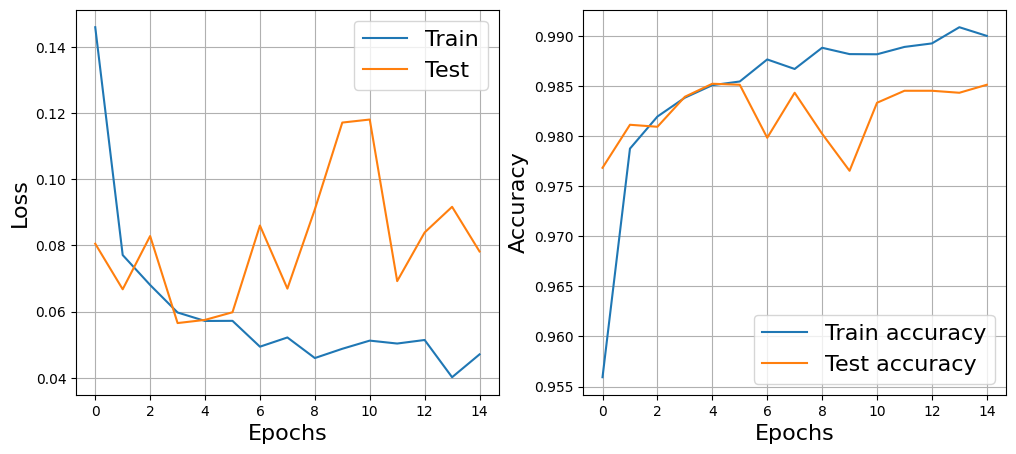

100%|██████████| 15/15 [03:12<00:00, 12.83s/it]


In [8]:
model=LeNet()
model.to(device)
lr = 0.0055

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=lr)

tr_lenet_adam1, ts_lenet_adam1, tr_ac_lenet_adam1, ts_ac_lenet_adam1 = train(
    model,train_loader_MNIST,test_loader_MNIST, epochs=15, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 9... (Train/Test) Loss: 0.215/0.200	Accuracy: 0.936/0.941

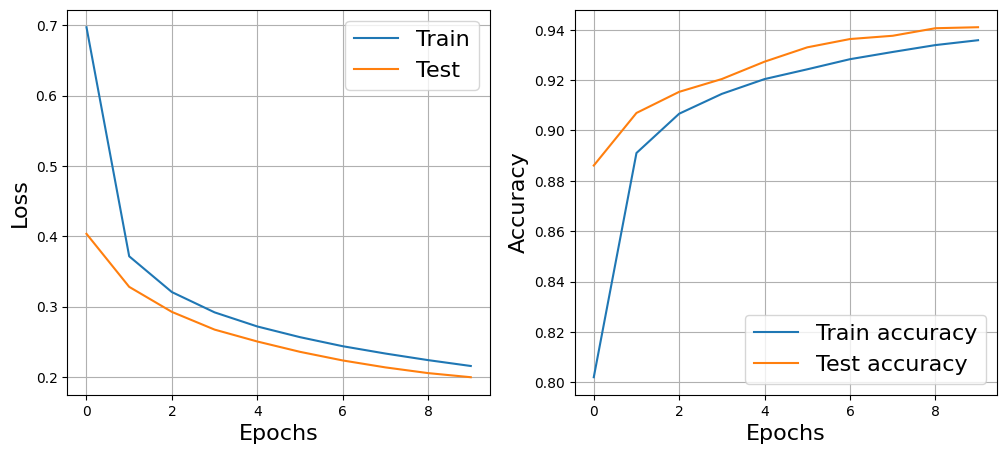

100%|██████████| 10/10 [02:07<00:00, 12.75s/it]


In [7]:
model=LeNet()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adagrad(model.parameters(), lr=lr)

tr_lenet_adagrad, ts_lenet_adagrad, tr_ac_lenet_adagrad, ts_ac_lenet_adagrad = train(
    model,train_loader_MNIST,test_loader_MNIST, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 9... (Train/Test) Loss: 0.070/0.057	Accuracy: 0.979/0.982

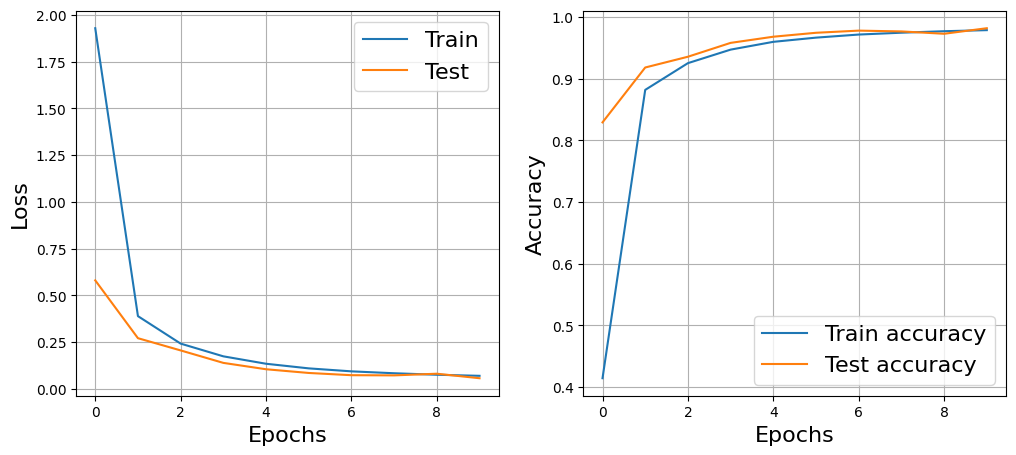

100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


In [6]:
model=LeNet()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8, nesterov=True)

tr_lenet_adagrad, ts_lenet_adagrad, tr_ac_lenet_adagrad, ts_ac_lenet_adagrad = train(
    model,train_loader_MNIST,test_loader_MNIST, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

## VGG

In [16]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


def fc_block(size_in, size_out,dropout):
    if dropout:
        layer = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.ReLU(),
            nn.Dropout(),
        )
    else:
        layer = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.ReLU(),
        )
    return layer


class VGG16(nn.Module):
    def __init__(self,dropout=True):
        super(VGG16, self).__init__()

        self.convs = nn.Sequential(
            conv_block(3, 128),
            conv_block(128, 256),
            conv_block(256, 512),
        )

        self.fc = nn.Sequential(
            fc_block(512*4*4, 1024,dropout),
            fc_block(1024, 1024,dropout),
            nn.Linear(1024, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Epoch 9... (Train/Test) Loss: 1.098/1.102	Accuracy: 0.655/0.653

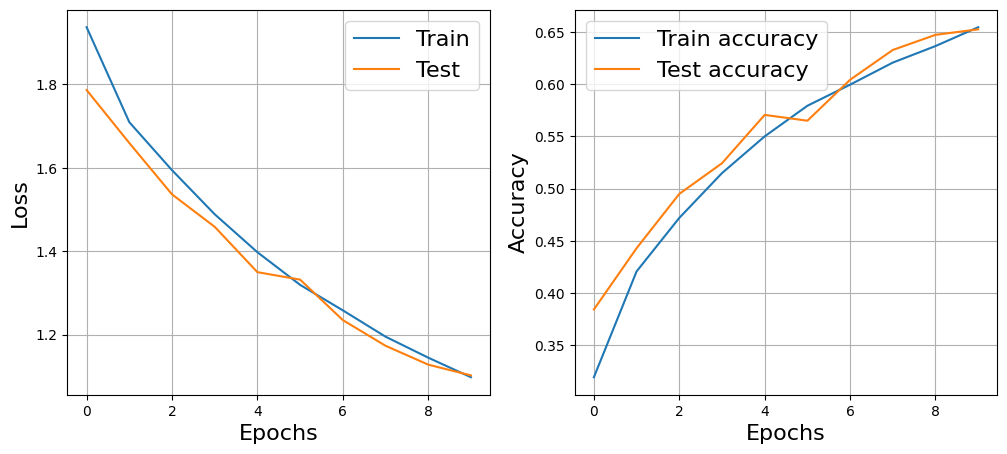

100%|██████████| 10/10 [08:32<00:00, 51.25s/it]


In [11]:
model=VGG16()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.SGD(model.parameters(), lr=lr)

tr_vgg16_sgd, ts_vgg16_sgd, tr_ac_vgg16_sgd, ts_ac_vgg16_sgd = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 9... (Train/Test) Loss: 0.469/0.563	Accuracy: 0.849/0.825

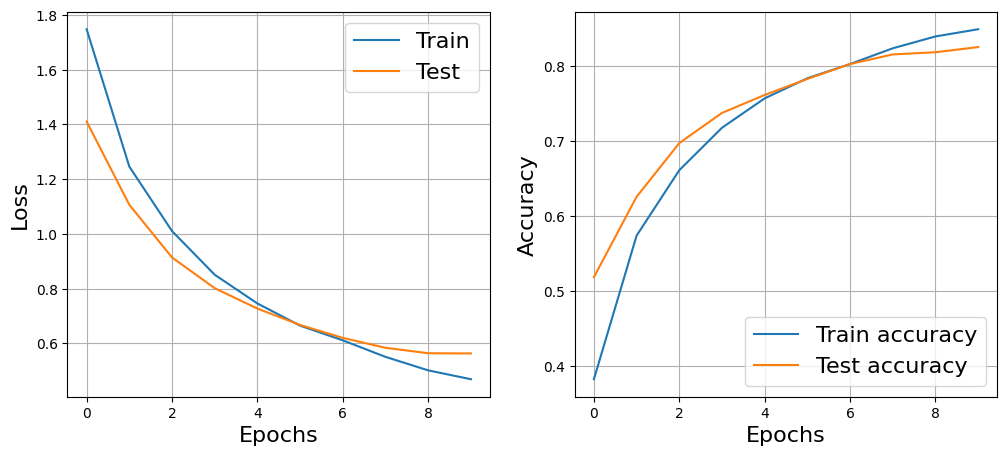

100%|██████████| 10/10 [09:28<00:00, 56.89s/it]


In [12]:
model=VGG16()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=lr)

tr_vgg16_adam, ts_vgg16_adam, tr_ac_vgg16_adam, ts_ac_vgg16_adam = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 9... (Train/Test) Loss: 0.866/0.906	Accuracy: 0.793/0.773

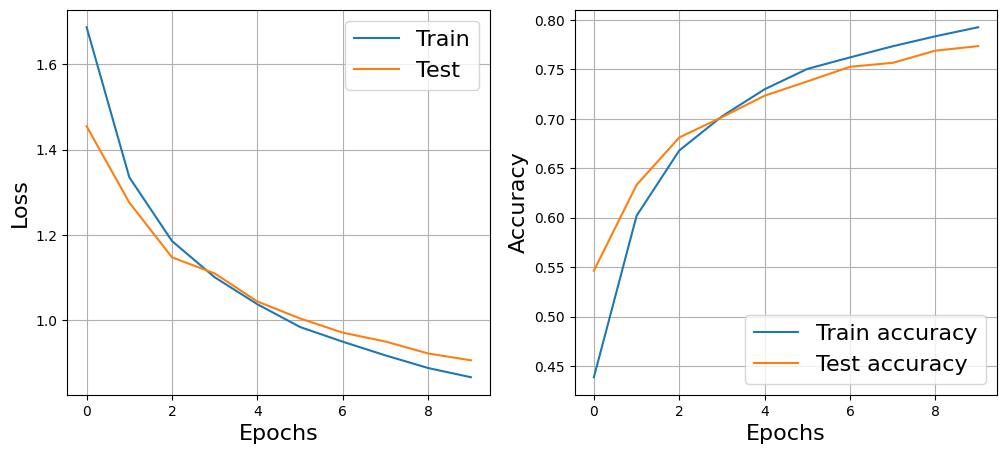

100%|██████████| 10/10 [09:11<00:00, 55.17s/it]


In [13]:
model=VGG16()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adagrad(model.parameters(), lr=lr)

tr_vgg16_adagrad, ts_vgg16_adagrad, tr_ac_vgg16_adagrad, ts_ac_vgg16_adagrad = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 9... (Train/Test) Loss: 0.679/0.710	Accuracy: 0.779/0.768

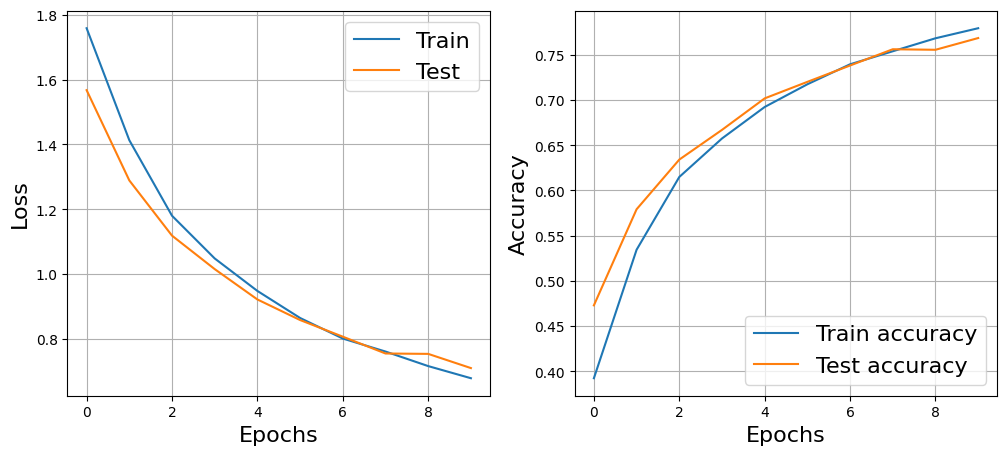

100%|██████████| 10/10 [09:01<00:00, 54.16s/it]


In [10]:
model=VGG16()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8, nesterov=True)

tr_vgg16_momentum, ts_vgg16_momentum, tr_ac_vgg16_momentum, ts_ac_vgg16_momentum = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

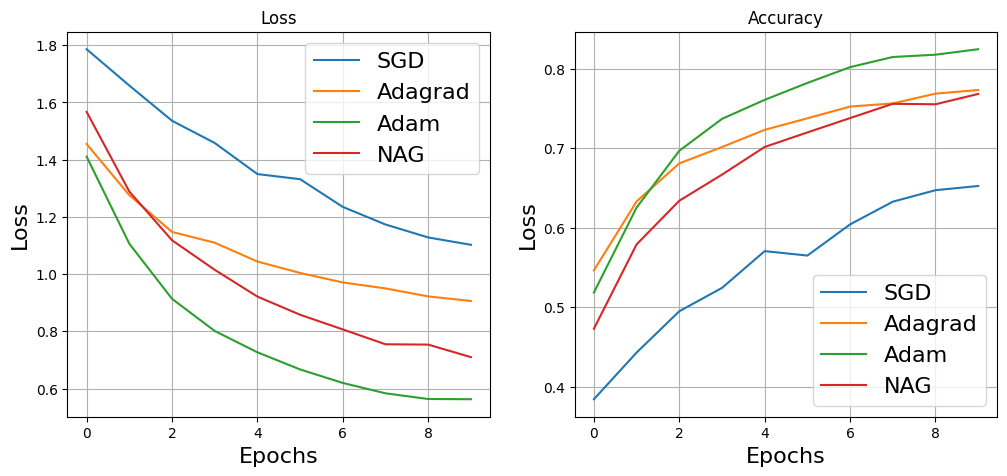

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_vgg16_sgd, label='SGD')
plt.plot(ts_vgg16_adagrad, label='Adagrad')
plt.plot(ts_vgg16_adam, label='Adam')
plt.plot(ts_vgg16_momentum, label='NAG')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_vgg16_sgd, label='SGD')
plt.plot(ts_ac_vgg16_adagrad, label='Adagrad')
plt.plot(ts_ac_vgg16_adam, label='Adam')
plt.plot(ts_ac_vgg16_momentum, label='NAG')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Epoch 9... (Train/Test) Loss: 0.462/0.514	Accuracy: 0.848/0.832

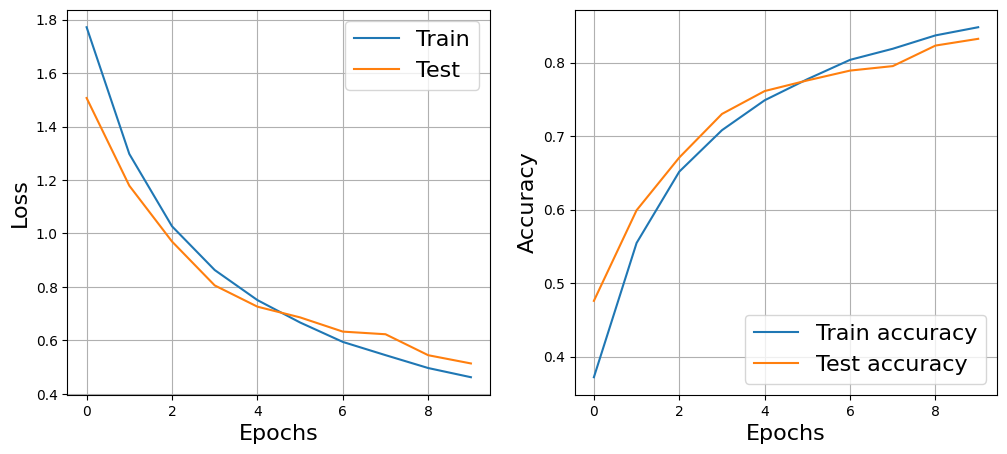

100%|██████████| 10/10 [09:29<00:00, 56.99s/it]


In [17]:
model=VGG16(dropout=False)
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=lr)

tr_vgg16_adam_nodrop, ts_vgg16_adam_nodrop, tr_ac_vgg16_adam_nodrop, ts_ac_vgg16_adam_nodrop = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

## ResNet


In [24]:
class ResidualBlock(nn.Module):
    expansion=1
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * out_channels)
                )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.in_planes = 16
        self.layer1 = self._make_layer(ResidualBlock, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=2)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(64),
            # nn.Linear(64, 128),
            # nn.ReLU(128),
            # nn.BatchNorm1d(128),
            # nn.Linear(128, 10),
            nn.Linear(64, 10),
            nn.ReLU(),
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet32():
    return ResNet([5, 5, 5])

Epoch 8... (Train/Test) Loss: 0.503/0.546	Accuracy: 0.828/0.816

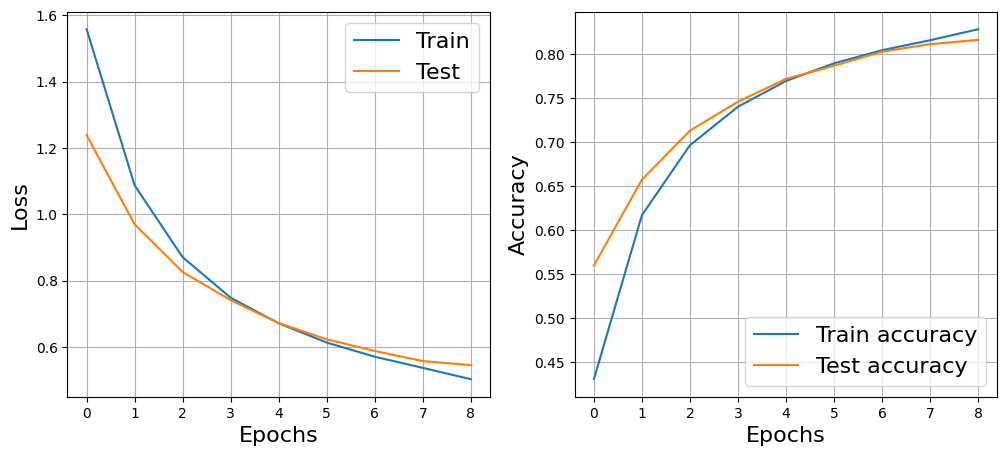

 90%|█████████ | 9/10 [08:15<00:54, 54.93s/it]

In [ ]:
model=resnet32()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=lr)

tr_resnet_adam, ts_resnet_adam, tr_ac_resnet_adam, ts_ac_resnet_adam = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 19... (Train/Test) Loss: 0.327/0.431	Accuracy: 0.888/0.854

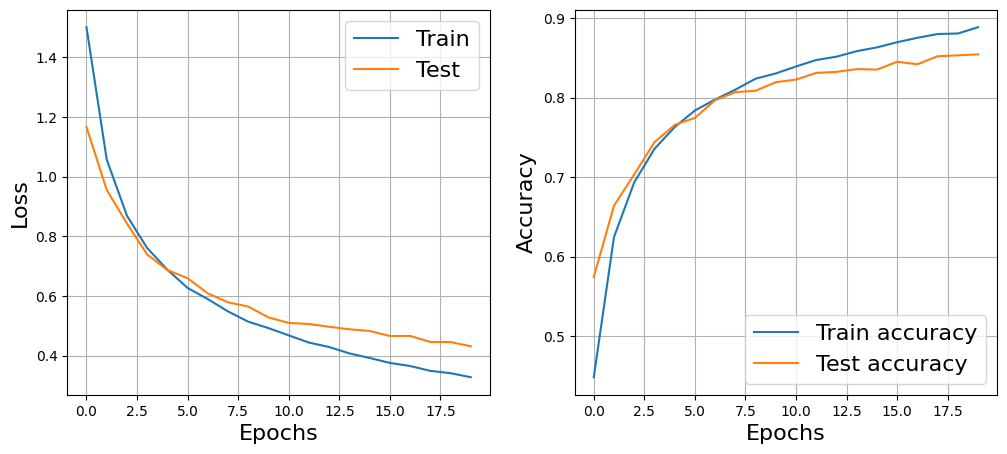

100%|██████████| 20/20 [18:17<00:00, 54.90s/it]


In [17]:
model=resnet32()
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(), lr=lr)

tr_resnet_adam, ts_resnet_adam, tr_ac_resnet_adam, ts_ac_resnet_adam = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=20, plot=True, verbose=True, loss_fn=loss, optim=optim)

Epoch 29... (Train/Test) Loss: 1.239/1.255	Accuracy: 0.565/0.557

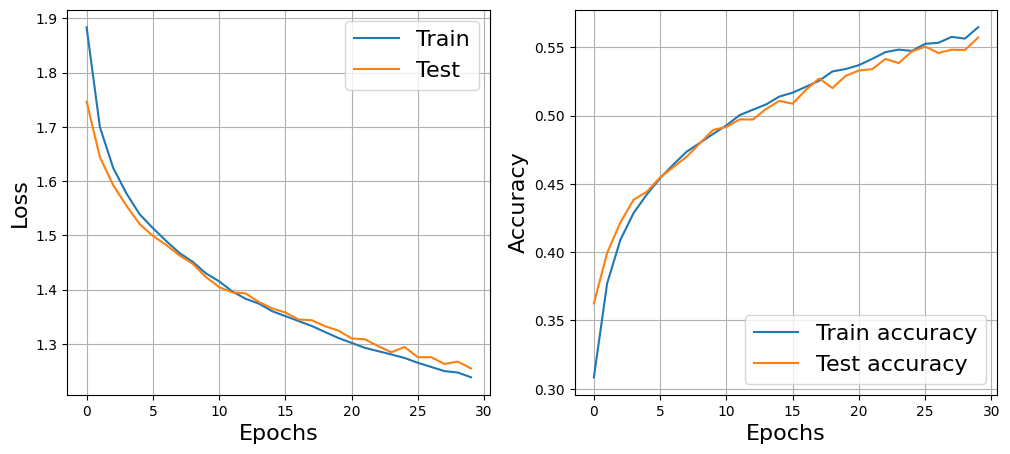

100%|██████████| 30/30 [27:25<00:00, 54.85s/it]


In [18]:
model=resnet32()
model.to(device)
lr = 0.0005

loss=nn.CrossEntropyLoss()
optim=torch.optim.Adagrad(model.parameters(), lr=lr)


tr_resnet_adam, ts_resnet_adam, tr_ac_resnet_adam, ts_ac_resnet_adam = train(
    model,train_loader_CIFAR,test_loader_CIFAR, epochs=30, plot=True, verbose=True, loss_fn=loss, optim=optim)